# February 3-7, 2023: Create a 2-cluster network and random networks: Simulate dynamics with Linear neural dynamics model

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
from scipy.spatial.distance import pdist, cdist, squareform
import tvb
import tvb.simulator.lab as tsl
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
from tvb.simulator.plot.timeseries_interactive import TimeSeriesInteractivePlotter

import networkx as nx

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/feb23"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

/home/govindas/.local/lib/python3.9/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

## network creation

In [3]:
def generate_roi_group(args, group=0):
    G = nx.powerlaw_cluster_graph(
        n=args.num_rois[group],
        m=args.m[group],
        p=args.p[group],
        seed=args.SEEDS[group],
    )
    roi_pos = nx.drawing.layout.fruchterman_reingold_layout(G, seed=args.SEEDS[group])
    W = nx.to_numpy_array(G)

    # tract lengths matrix
    roi_pos = np.stack(list(roi_pos.values()), axis=0) + args.roi_pos_shift[group]
    tract_lengths = args.scale*5 * np.round(
        squareform(
            pdist(
                X=roi_pos,
                metric='euclidean',
            )
        )
    )
    tract_lengths = np.ones_like(tract_lengths)
    tract_lengths *= W
    G_tl = nx.from_numpy_array(tract_lengths)
    W *= tract_lengths>0
    # nx.draw(
    #     G_tl,
    #     pos=roi_pos,
    #     width=[G_tl[u][v]['weight'] for u, v in G_tl.edges()]
    # )
    
    # weights matrix
    weights = np.triu(np.random.rand(args.num_rois[group], args.num_rois[group]), k=1)
    # weights = np.triu(np.ones(shape=(args.num_rois[group], args.num_rois[group])), k=1)
    weights = (weights + weights.T)/2
    weights *= W
    weights *= args.scale
    G_weights = nx.from_numpy_array(weights)
    # nx.draw(
    #     nx.from_numpy_array(weights),
    #     pos=roi_pos,
    #     width=[G_weights[u][v]['weight'] for u, v in G_weights.edges()]
    # )

    # roi labels
    label = args.group_label[group]
    roi_labels = [f"{label}_{roi:02}" for roi in range(len(roi_pos))]

    return weights, tract_lengths, roi_pos, roi_labels

In [4]:
def arrange_submatrices(args, mat1, mat2, inter):
    row1 = np.hstack(
        [mat1, inter],
    )
    row2 = np.hstack(
        [inter.T, mat2],
    )
    mat = np.vstack([row1, row2])
    return mat

In [5]:
def generate_connectivity_matrix(args, ):
    # intra-group excitatory connections
    group1 = generate_roi_group(args, group=0)
    group2 = generate_roi_group(args, group=1)

    # inter-group inhibitory connections
    inter = np.random.rand(*args.num_rois)
    inter[inter < 1-args.p_out] = 0.0 
    inter[inter >= 1-args.p_out] = 1.0 

    inter_lengths = args.scale * np.round(
        cdist(
            XA=group1[2], 
            XB=group2[2], 
            metric='euclidean'
        )
    )
    inter_lengths = np.ones_like(inter_lengths)
    inter_lengths *= inter
    

    inter *= inter_lengths>0
    # inter_weights = inter * -args.scale*np.random.rand(*args.num_rois)
    inter_weights = inter * -1 * args.scale

    # combine all
    weights = arrange_submatrices(
        args, 
        group1[0],
        group2[0],
        inter_weights
    )
    tract_lengths = arrange_submatrices(
        args, 
        group1[1],
        group2[1],
        inter_lengths,
    )
    roi_pos = np.vstack([group1[2], group2[2]])
    roi_labels = np.array(group1[3] + group2[3])
    hemispheres = np.array(
        [False for _ in range(len(group1[2]))] +
        [True for _ in range(len(group2[2]))]
    )

    return (
        weights, 
        tract_lengths, 
        roi_pos, 
        roi_labels,
        hemispheres
    )

In [6]:
def create_matrix_ticks(args):
    args.ticks = args.num_rois
    minor_ticks = np.cumsum(args.ticks)
    args.major_ticks = minor_ticks - args.ticks // 2
    args.minor_ticks = minor_ticks[:-1]
    args.major_tick_labels = args.group_label
    return args

def set_matrix_ticks(args, ax):
    try:
        ax.set_yticks(args.major_ticks, args.major_tick_labels, rotation=0, va='center')
        ax.set_xticks(args.major_ticks, args.major_tick_labels, rotation=90, ha='center')

        ax.set_yticks(args.minor_ticks-0.5, minor=True)
        ax.set_xticks(args.minor_ticks-0.5, minor=True)
        ax.tick_params(
            which='major', direction='out', length=5.5, 
            # grid_color='white', grid_linewidth='1.5',
            labelsize=10,
        )
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)
    except:
        pass

def display_network(args, network):
    nrows, ncols = 1, 2
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    nws = {'weights': network.weights, 'tract_lengths': network.tract_lengths}

    for idx, (name, nw) in enumerate(nws.items()):
        ax = axs[idx]
        im = ax.imshow(nw, cmap=args.cmap)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_title(f"{name}")
        set_matrix_ticks(args, ax)

    return None

In [7]:
def plot_roi_time_series(args, time, data, roi_labels):
    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 5)), 5
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=False, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.65
    )

    state_var = 0

    for idx_roi, roi in enumerate(np.arange(data.shape[2])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        

        ax.set_title(f"{roi_labels[roi]}")

        ax.plot(
            data[:, state_var, idx_roi, 0],
            color='cornflowerblue',
            linewidth=3,
        )

        # ax.fill_between()

        ax.set_xlabel(f"time (s)")
        ax.set_ylabel(f"activity")

        spc = len(time) // 5
        pos = np.arange(0, len(time), spc)
        labels = np.round(time[::spc]) / 1000
        #f"{np.array2string(time[::spc], precision=2, floatmode='fixed')}".split(" ")
        ax.set_xticks(pos, labels)
        ax.grid(True)

    # fig.show()

    return None

In [8]:
def define_tvb_network(args, weights, tract_lengths, roi_pos, roi_labels, hemispheres):
    network = tsl.connectivity.Connectivity()
    num_rois = weights.shape[0]
    network.set_weights(weights, num_rois)
    network.set_tract_lengths(tract_lengths, num_rois)
    network.set_centres(roi_pos, num_rois)
    network.set_region_labels(roi_labels)
    network.set_hemispheres(hemispheres, num_rois)
    network.configure()

    args.cmap = cmr.iceburn
    display_network(args, network)

    return network

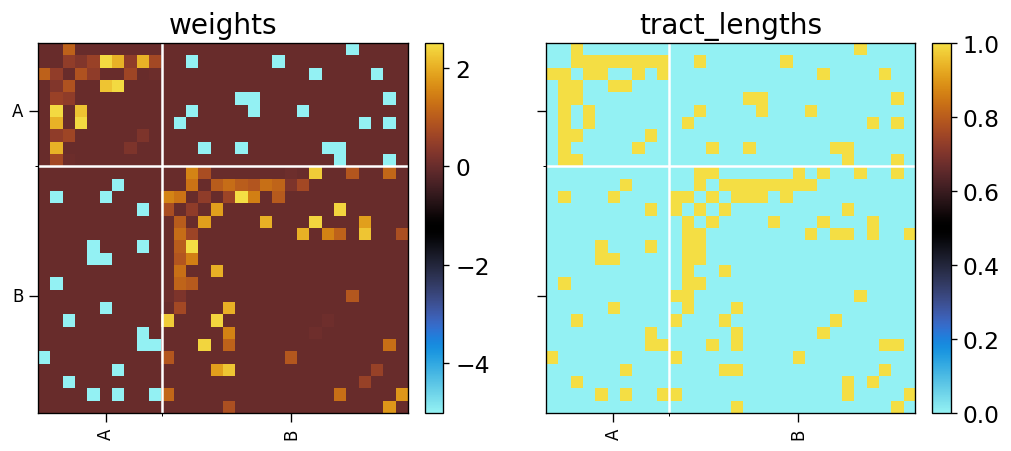

In [9]:
args.SEEDS = [100, 50]
args.num_rois = np.array([10, 20])
args.m = [2, 2]
args.p = [0.1, 0.1]
args.scale = 5
args.group_label = ['A', 'B']
args.roi_pos_shift = [(-2, 0), (2,0)]
args.p_out = 0.1

(
    weights, 
    tract_lengths,
    roi_pos,
    roi_labels,
    hemispheres
) = generate_connectivity_matrix(args)

args = create_matrix_ticks(args)

network = define_tvb_network(
    args, 
    weights, 
    tract_lengths,
    roi_pos,
    roi_labels,
    hemispheres,
)

## time series generation

In [10]:
# class Stim(tsl.patterns.StimuliRegion):
#     def __init__(self, *args, **kwargs):
#         super(Stim, self).__init__(*args, **kwargs)
    
#     def __call__(self, time, space=None):
#         num_rois = self.state.shape[1]
#         self.stimulus = (1 - self.state) * np.ones(num_rois)
#         return self.stimulus

#     def set_state(self, state):
#         self.state = state
    
#     def configure_time(self, t):
#         pass

In [11]:
def define_tvb_stimulus(args):
    # stimulus
    args.roi_weights = np.zeros(np.sum(args.num_rois))
    # args.roi_weights[:args.num_rois[0]] = 1.0
    args.roi_weights[args.roi_idxs] = 1.0

    eq = tvb.datatypes.equations.PulseTrain()
    eq.parameters['onset'] = 0.0 # ms 
    eq.parameters['T'] = 200.0 # ms
    eq.parameters['tau'] = 100.0 # ms
    eq.parameters['amp'] = 5.0 # A.U.

    stimulus = tsl.patterns.StimuliRegion(
        temporal=eq,
        connectivity=network,
        weight=args.roi_weights,
    )
    stimulus.configure()

    # plot stimulus
    time = np.arange(0.0, 5e2, 0.01)
    y = stimulus.temporal.evaluate(time)
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=1,
        figsize=(8, 3),
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    ax = axs
    ax.set_title(f"Stimulus")
    ax.plot(y)
    ax.set_xlabel(f"time (s)")
    ax.set_ylabel(f"stimulus value")

    spc = len(time) // 5
    pos = np.arange(0, len(time), spc)
    labels = np.round(time[::spc]) / 1000
    #f"{np.array2string(time[::spc], precision=2, floatmode='fixed')}".split(" ")
    ax.set_xticks(pos, labels)
    ax.grid(True)

    return stimulus

In [12]:
def define_tvb_neural_dynamics(args):
    # neural dynamics
    model = tsl.models.Linear(
        gamma=np.array([-0.5]),
    )
    coupling = tsl.coupling.HyperbolicTangent()
    integrator = tsl.integrators.HeunDeterministic(dt=2**-6)
    # integrator = tsl.integrators.HeunStochastic(
    #     dt=2**-6, 
    #     noise=tsl.noise.Additive(nsig=np.array([args.nsig]))
    # )
    monitors = (
        tsl.monitors.RawVoi(),
        tsl.monitors.ProgressLogger(period=1e3),
    )

    return model, coupling, integrator, monitors

In [13]:
def tvb_simulation(args, model, network, coupling, integrator, monitors, stimulus):
    # simulation
    sim = tsl.simulator.Simulator(
        model=model, 
        connectivity=network, 
        conduction_speed=args.speed,
        coupling=coupling, 
        integrator=integrator,
        monitors=monitors,
        stimulus=stimulus,
        simulation_length=args.sim_length,
    ).configure()

    sim.initial_conditions = np.zeros(shape=(*sim.good_history_shape,))
    # stimulus.set_state(np.zeros((sim.model.nvar, network.weights.shape[0], 1)))

    # time = []
    # data = []
    # for (raw_voi) in sim():
    #     # stimulus.set_state(raw_voi[0][1])
    #     time.append(raw_voi[0][0])
    #     data.append(raw_voi[0][1])
    # data = np.stack(data, axis=0)

    run_res = sim.run()
    time, data = run_res[0]
    # `data` dimensions are ("Time", "State Variable", "Region", "Mode")
    time.shape, data.shape

    args.num_rois = np.sum(args.num_rois)
    args.subplot_layout = 'row-col'
    plot_roi_time_series(args, time, data, sim.connectivity.region_labels)

    return sim, #time, data

WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0000 s


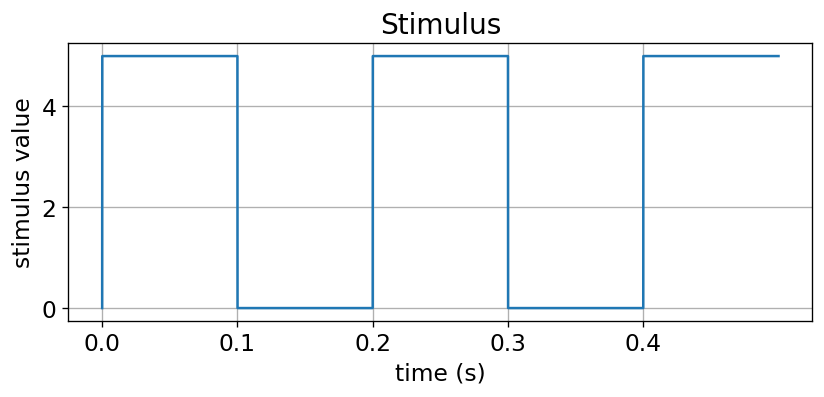

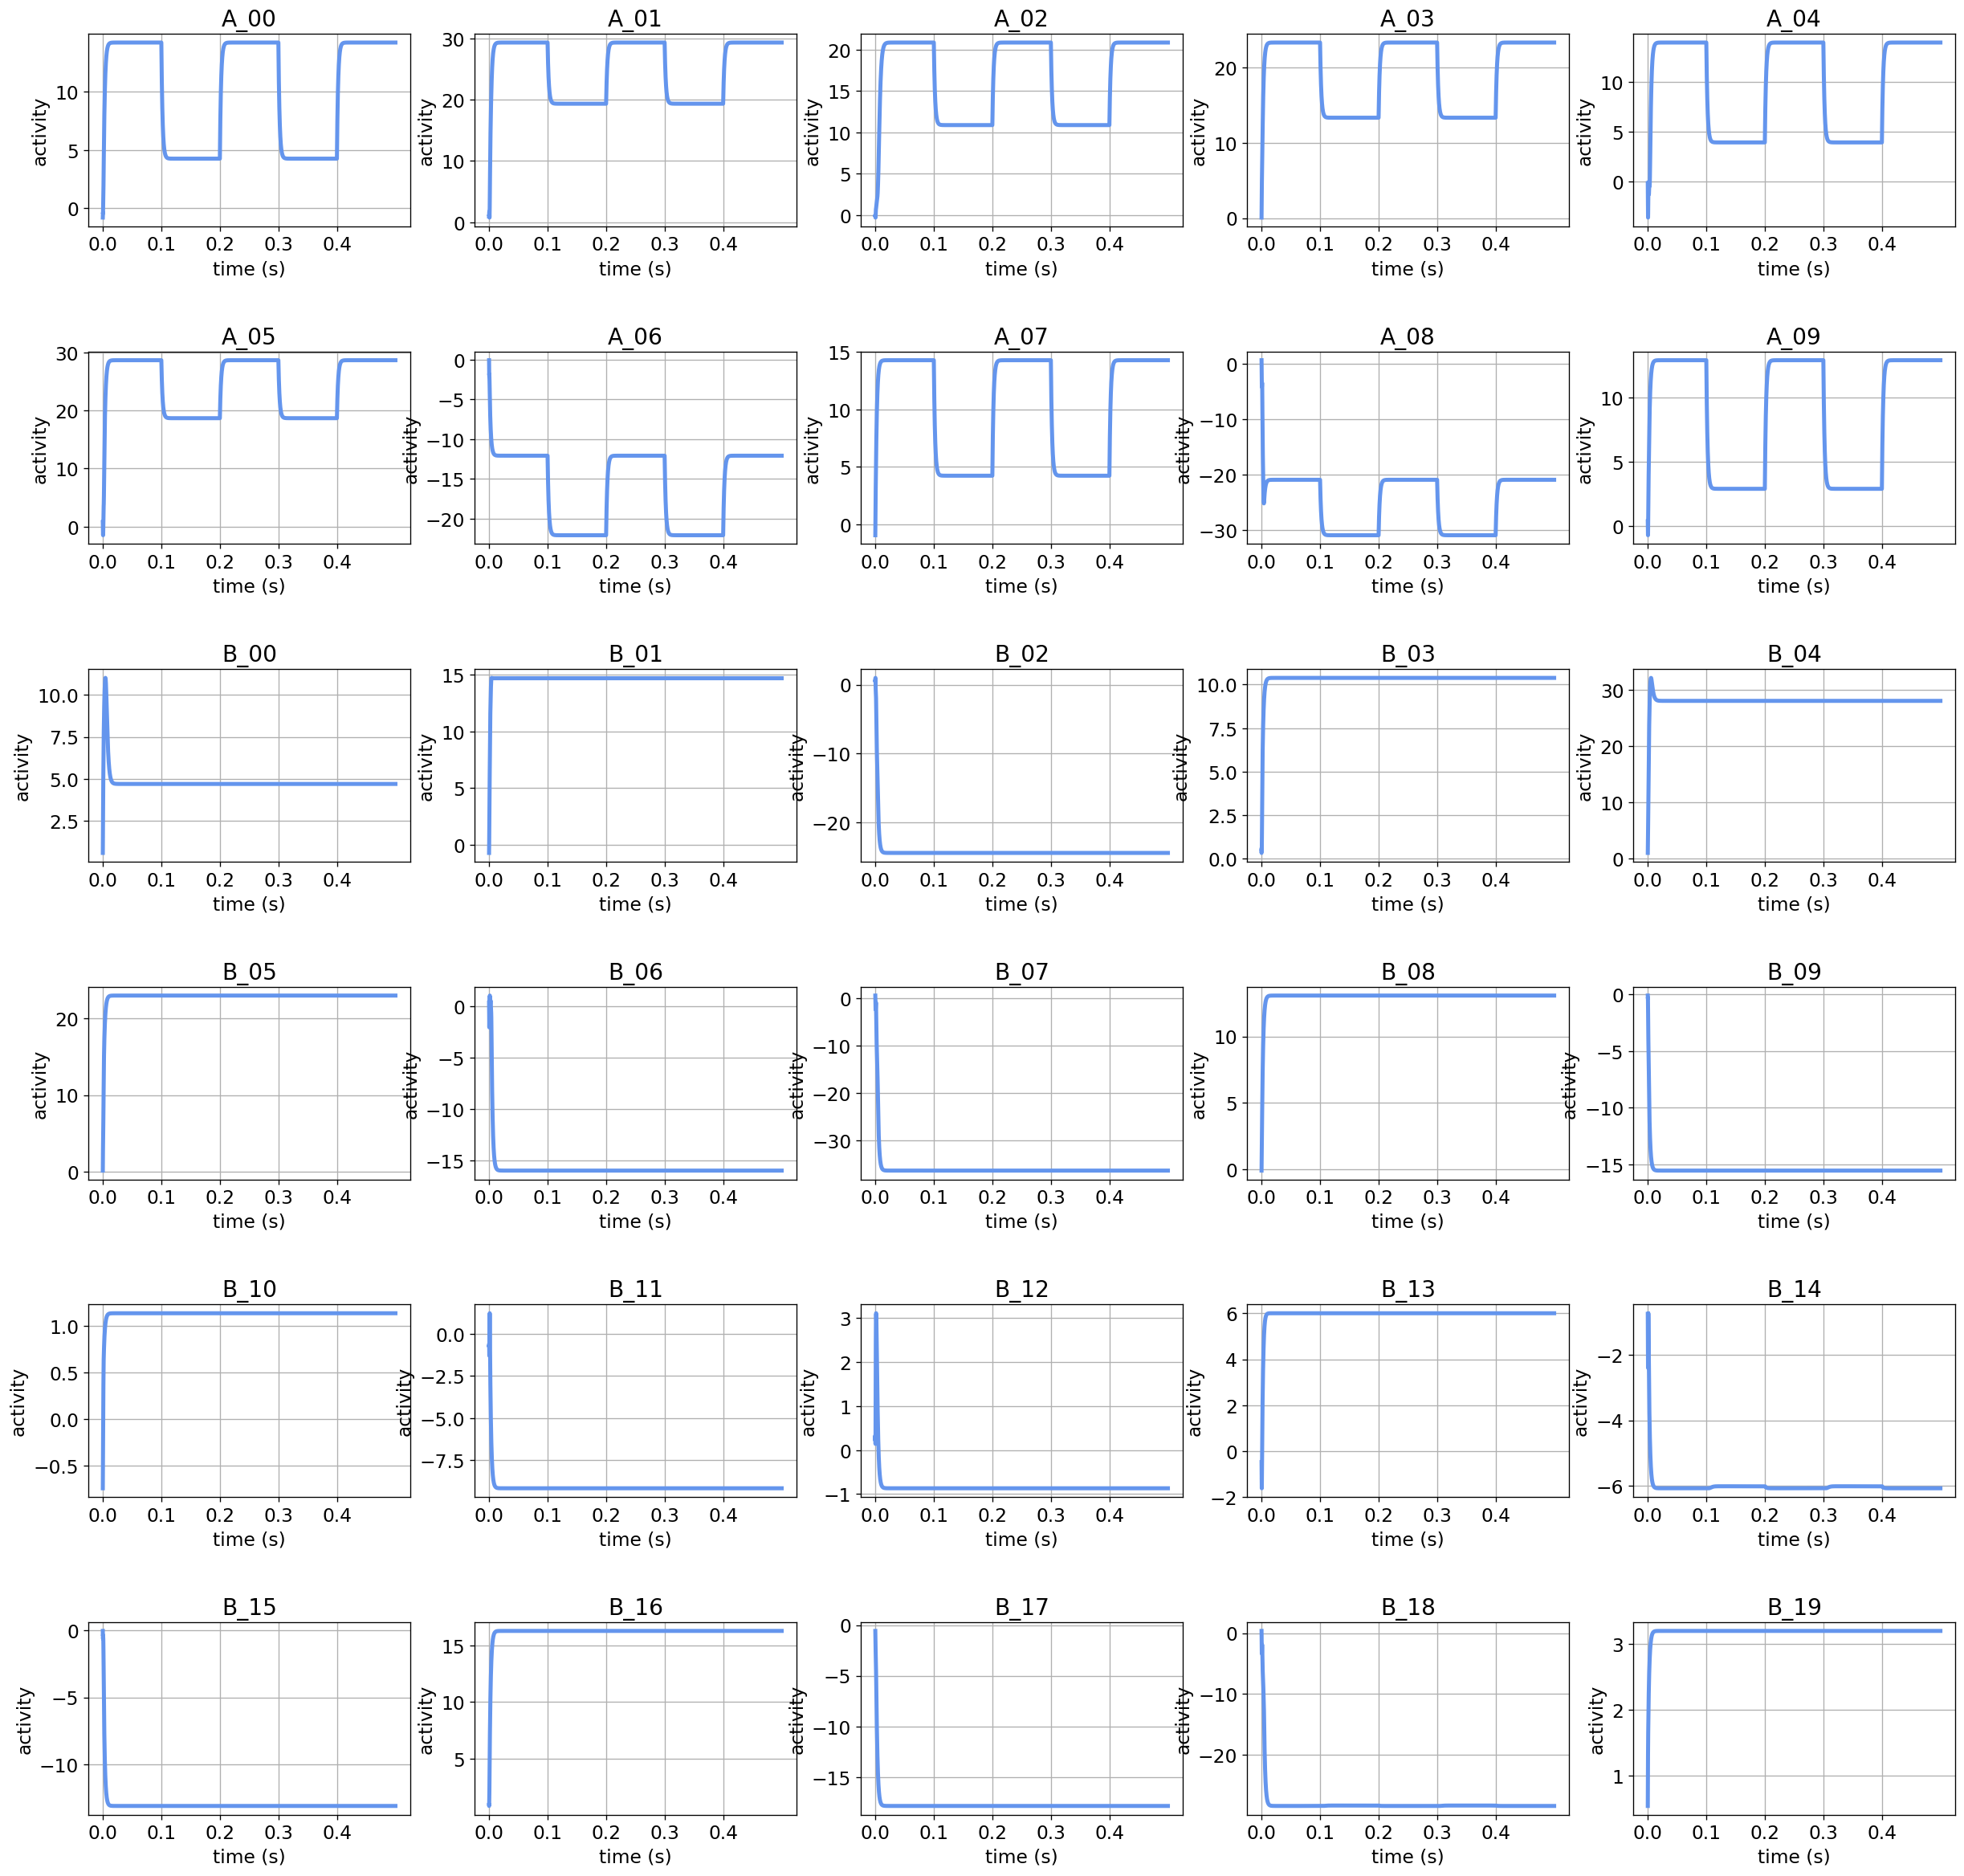

In [14]:
args.roi_idxs = np.arange(0, 10, 1)
stimulus = define_tvb_stimulus(args)
# stimulus = Stim()

args.nsig = 0.001
(
    model, 
    coupling, 
    integrator, 
    monitors,
) = define_tvb_neural_dynamics(args)

args.speed = 3.0
args.sim_length = 5e2
(
    sim, 
    # time, 
    # data,
) = tvb_simulation(
    args, 
    model, 
    network, 
    coupling, 
    integrator, 
    monitors, 
    stimulus,
)